In [1]:
%pwd

'/home/zwx/segment-anything-flask/test'

In [2]:
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
import numpy as np

In [3]:
def show_mask(mask, ax):
  color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

## Load a demo image

In [4]:
path2img = "../assets/dog.jpg"
image = cv2.imread(path2img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

(193, 261, 3)


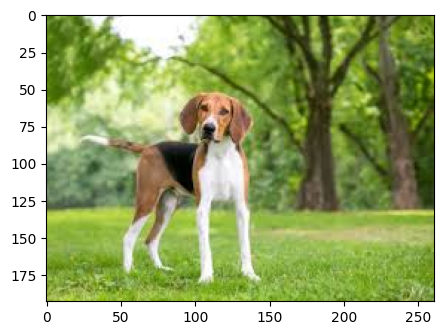

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

## Load the SAM model and predictor

In [6]:
path2ckpt = "../assets/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"

In [7]:
sam = sam_model_registry[model_type](checkpoint=path2ckpt)
sam.to(device=device)
predictor = SamPredictor(sam)

## Embedding the image

In [8]:
'''
Process the image to produce an image embedding by calling SamPredictor.set_image.
SamPredictor remembers this embedding and will use it for subsequent mask prediction.
'''
predictor.set_image(image)

## Select a point on a object in the image

In [9]:
'''
the point (x, y) that will be passed to mask decoder
+——————————+
|    | y   |
+----+     | height
|  x       |
+——————————+
    width
'''
input_point = np.array([[100, 100]])
input_label = np.array([1])

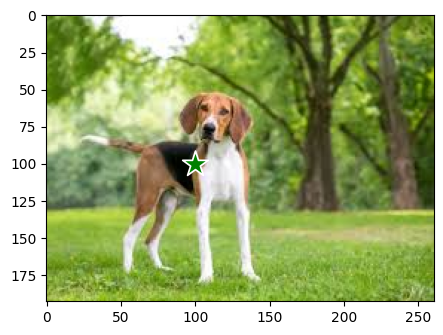

In [10]:
'''show the point'''
plt.figure(figsize=(5,5))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

## Decode the embedding with point prompt to get mask

Predict with SamPredictor.predict. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = predictor.predict(
  point_coords=input_point,
  point_labels=input_label,
  multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where scores gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When False, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use multimask_output=True even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in scores. This will often result in a better mask.

In [15]:
print(f"masks.shape: {masks.shape}, type: {type(masks)}")
print(f"masks[0].shape: {masks[0].shape}")

masks.shape: (3, 193, 261), type: <class 'numpy.ndarray'>
masks[0].shape: (193, 261)


In [16]:
print(f"scores.shape: {scores.shape}, type: {type(scores)}")

scores.shape: (3,), type: <class 'numpy.ndarray'>


## Display the 3 result masks

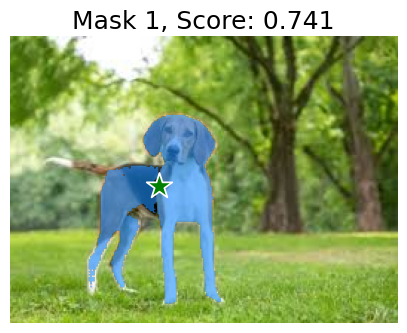

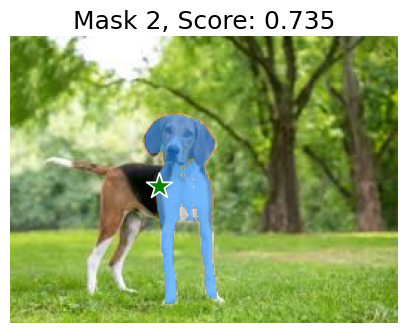

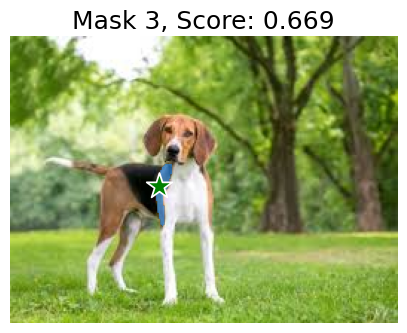

In [14]:
for i, (mask, score) in enumerate(zip(masks, scores)):
  plt.figure(figsize=(5,5))
  plt.imshow(image)
  show_mask(mask, plt.gca())
  show_points(input_point, input_label, plt.gca())
  plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
  plt.axis('off')
  plt.show()  